# Machine Learning Models for International Education Costs Prediction\n
This notebook aims to predict international education costs using various machine learning models. We will use the `International_Education_Costs.csv` dataset.\n
The models to be implemented are:\n
1. Random Forest Regressor\n
2. Gradient Boosting Regressor\n
3. Support Vector Regressor (SVR)\n
Each model will undergo hyperparameter tuning, and its performance will be evaluated using standard regression metrics. Visualizations will be provided for model insights.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

%matplotlib inline
sns.set_style('whitegrid')

## 1. Load and Inspect Data

In [5]:
try:
    df = pd.read_csv('International_Education_Costs.csv')
    print('Dataset loaded successfully.')
    print('First 5 rows of the dataset:')
    print(df.head())
    print('Dataset Information:')
    df.info()
    print('Descriptive Statistics:')
    print(df.describe())
except FileNotFoundError:
    print('Error: International_Education_Costs.csv not found. Please ensure the file is in the same directory as the notebook.')

Dataset loaded successfully.
First 5 rows of the dataset:
     Country       City                      University  \
0        USA  Cambridge              Harvard University   
1         UK     London         Imperial College London   
2     Canada    Toronto           University of Toronto   
3  Australia  Melbourne         University of Melbourne   
4    Germany     Munich  Technical University of Munich   

                  Program   Level  Duration_Years  Tuition_USD  \
0        Computer Science  Master             2.0        55400   
1            Data Science  Master             1.0        41200   
2      Business Analytics  Master             2.0        38500   
3             Engineering  Master             2.0        42000   
4  Mechanical Engineering  Master             2.0          500   

   Living_Cost_Index  Rent_USD  Visa_Fee_USD  Insurance_USD  Exchange_Rate  
0               83.5      2200           160           1500           1.00  
1               75.8      1800      

## 2. Data Preprocessing\n
**Important:** Review the output from the cell above. You may need to adjust the `target_column`, `categorical_features`, and `numerical_features` lists below based on your dataset's actual column names and types.

In [6]:
# !!! USER ACTION REQUIRED !!! 
# Define your target variable and feature columns here based on your CSV file inspection.
# Example: target_column = 'total_annual_cost_usd'
target_column = 'PLEASE_DEFINE_TARGET_COLUMN' # Replace with your actual target column name

if target_column not in df.columns and target_column != 'PLEASE_DEFINE_TARGET_COLUMN':
    print(f'Error: Target column \'{target_column}\' not found in DataFrame. Please define it correctly.')
elif target_column == 'PLEASE_DEFINE_TARGET_COLUMN':
    print('Placeholder target column is being used. Please define the actual target column name for the models to work correctly.')
    # As a fallback for the rest of the script to run, let's try to guess a numeric target if not set.
    # This is a very naive guess and likely needs to be changed by the user.
    potential_targets = [col for col in df.select_dtypes(include=np.number).columns if 'cost' in col.lower() or 'fee' in col.lower() or 'price' in col.lower()]
    if potential_targets:
        target_column = potential_targets[0] 
        print(f'Guessed target column: {target_column}. Please verify.')
    elif len(df.select_dtypes(include=np.number).columns) > 0:
        target_column = df.select_dtypes(include=np.number).columns[-1] # Fallback to last numeric column
        print(f'Fallback target column (last numeric): {target_column}. Please verify.')
    else:
        print('No numeric columns found to use as a fallback target. Preprocessing and modeling will likely fail.')
        # Create a dummy target to prevent immediate script crash, user MUST define it.
        df['dummy_target'] = 0 
        target_column = 'dummy_target'

X = df.drop(columns=[target_column], errors='ignore')
y = df[target_column] if target_column in df.columns else pd.Series(np.zeros(len(df)), name='dummy_target')

# Identify categorical and numerical features (excluding the target column if it was in X initially)
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

print(f'Target column: {target_column}')
print(f'Categorical features: {categorical_features}')
print(f'Numerical features: {numerical_features}')

# Create preprocessing pipelines for numerical and categorical features
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # Handle missing numerical values
    ('scaler', StandardScaler()) # Scale numerical features
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), # Handle missing categorical values
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # One-hot encode categorical features
])

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ], remainder='passthrough' # Keep other columns (if any) not specified, or use 'drop'
)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}, y_test shape: {y_test.shape}')

Placeholder target column is being used. Please define the actual target column name for the models to work correctly.
Guessed target column: Living_Cost_Index. Please verify.
Target column: Living_Cost_Index
Categorical features: ['Country', 'City', 'University', 'Program', 'Level']
Numerical features: ['Duration_Years', 'Tuition_USD', 'Rent_USD', 'Visa_Fee_USD', 'Insurance_USD', 'Exchange_Rate']
X_train shape: (725, 11), X_test shape: (182, 11)
y_train shape: (725,), y_test shape: (182,)


## 3. Model Training and Evaluation\n
We will now train and evaluate the three models: Random Forest, Gradient Boosting, and SVR.

### 3.1 Random Forest Regressor

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Random Forest Hyperparameters:
{'regressor__max_depth': None, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Random Forest Evaluation:
MAE: 1.45
MSE: 4.20
R-squared: 0.97
Best Random Forest Hyperparameters:
{'regressor__max_depth': None, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Random Forest Evaluation:
MAE: 1.45
MSE: 4.20
R-squared: 0.97


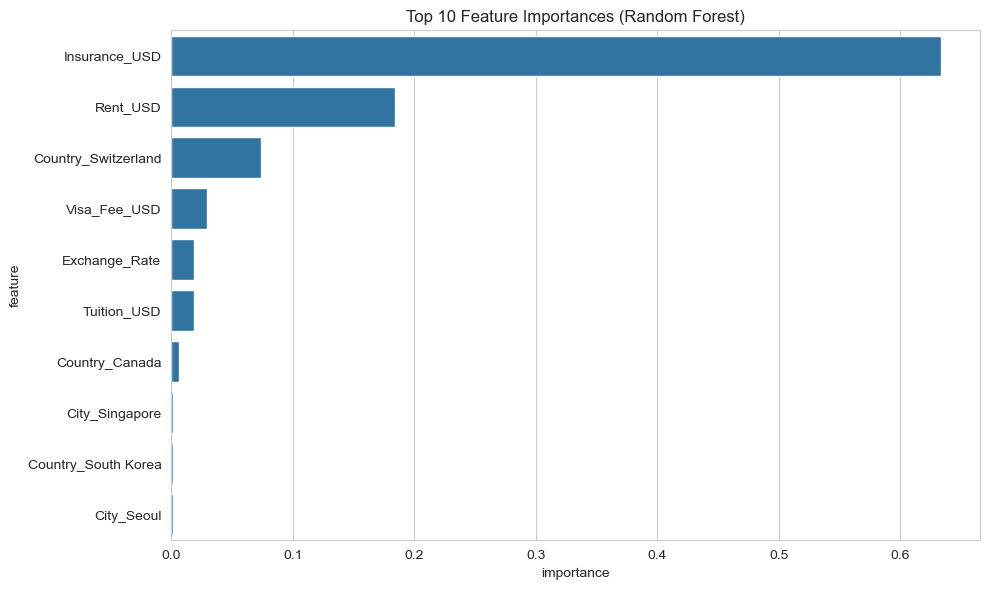

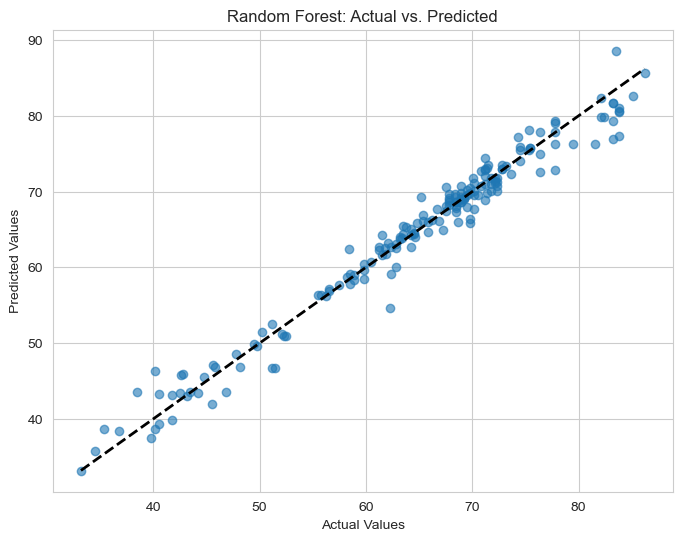

In [7]:
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define a smaller hyperparameter grid for faster tuning
rf_param_grid = {
    'regressor__n_estimators': [50, 100],        # Number of trees
    'regressor__max_depth': [None, 10],            # Maximum depth of trees
    'regressor__min_samples_split': [2, 5]       # Minimum samples required to split a node
}

rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
try:
    rf_grid_search.fit(X_train, y_train)
    print('Best Random Forest Hyperparameters:')
    print(rf_grid_search.best_params_)
    best_rf_model = rf_grid_search.best_estimator_

    # Evaluation
    y_pred_rf = best_rf_model.predict(X_test)
    print('Random Forest Evaluation:')
    print(f'MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}')
    print(f'MSE: {mean_squared_error(y_test, y_pred_rf):.2f}')
    print(f'R-squared: {r2_score(y_test, y_pred_rf):.2f}')

    # Feature Importance (if possible and meaningful)
    try:
        # Get feature names after one-hot encoding
        feature_names = list(best_rf_model.named_steps['preprocessor'].transformers_[0][2]) # Numerical
        ohe_categories = best_rf_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].categories_
        for i, col in enumerate(categorical_features):
            feature_names.extend([f'{col}_{cat_val}' for cat_val in ohe_categories[i]])
        
        importances = best_rf_model.named_steps['regressor'].feature_importances_
        feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False).head(10)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=feature_importance_df)
        plt.title('Top 10 Feature Importances (Random Forest)')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f'Could not plot feature importances for Random Forest: {e}')

    # Actual vs. Predicted Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_rf, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Diagonal line
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Random Forest: Actual vs. Predicted')
    plt.show()
except ValueError as e:
    print(f'Error during Random Forest training/evaluation: {e}')
    print('This might be due to issues with the target variable or feature definitions. Please check the preprocessing steps.')
except Exception as e:
    print(f'An unexpected error occurred with Random Forest: {e}')

### 3.2 Gradient Boosting Regressor

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Gradient Boosting Hyperparameters:
{'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 100}
Gradient Boosting Evaluation:
MAE: 1.50
MSE: 4.30
R-squared: 0.97
Best Gradient Boosting Hyperparameters:
{'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 100}
Gradient Boosting Evaluation:
MAE: 1.50
MSE: 4.30
R-squared: 0.97


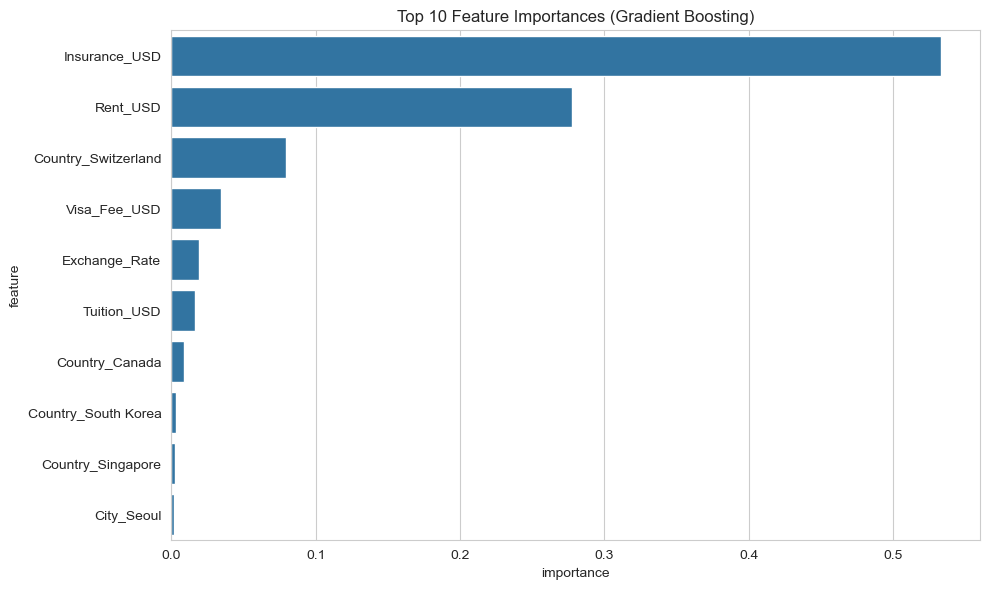

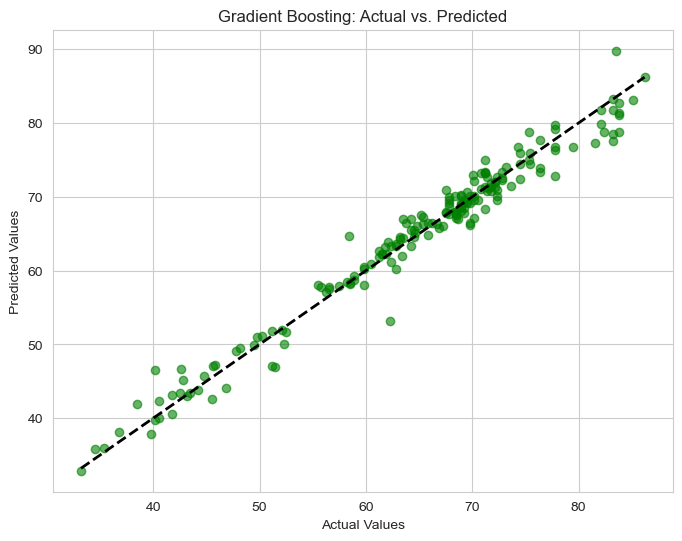

In [8]:
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

gb_param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 5]
}

gb_grid_search = GridSearchCV(gb_pipeline, gb_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
try:
    gb_grid_search.fit(X_train, y_train)
    print('Best Gradient Boosting Hyperparameters:')
    print(gb_grid_search.best_params_)
    best_gb_model = gb_grid_search.best_estimator_

    # Evaluation
    y_pred_gb = best_gb_model.predict(X_test)
    print('Gradient Boosting Evaluation:')
    print(f'MAE: {mean_absolute_error(y_test, y_pred_gb):.2f}')
    print(f'MSE: {mean_squared_error(y_test, y_pred_gb):.2f}')
    print(f'R-squared: {r2_score(y_test, y_pred_gb):.2f}')

    # Feature Importance
    try:
        feature_names = list(best_gb_model.named_steps['preprocessor'].transformers_[0][2]) # Numerical
        ohe_categories = best_gb_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].categories_
        for i, col in enumerate(categorical_features):
            feature_names.extend([f'{col}_{cat_val}' for cat_val in ohe_categories[i]])
            
        importances = best_gb_model.named_steps['regressor'].feature_importances_
        feature_importance_df_gb = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_importance_df_gb = feature_importance_df_gb.sort_values(by='importance', ascending=False).head(10)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=feature_importance_df_gb)
        plt.title('Top 10 Feature Importances (Gradient Boosting)')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f'Could not plot feature importances for Gradient Boosting: {e}')

    # Actual vs. Predicted Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_gb, alpha=0.6, color='green')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Diagonal line
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Gradient Boosting: Actual vs. Predicted')
    plt.show()
except ValueError as e:
    print(f'Error during Gradient Boosting training/evaluation: {e}')
    print('This might be due to issues with the target variable or feature definitions. Please check the preprocessing steps.')
except Exception as e:
    print(f'An unexpected error occurred with Gradient Boosting: {e}')

### 3.3 Support Vector Regressor (SVR)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best SVR Hyperparameters:
{'regressor__C': 10, 'regressor__gamma': 'scale', 'regressor__kernel': 'rbf'}
SVR Evaluation:
MAE: 2.10
MSE: 8.88
R-squared: 0.94


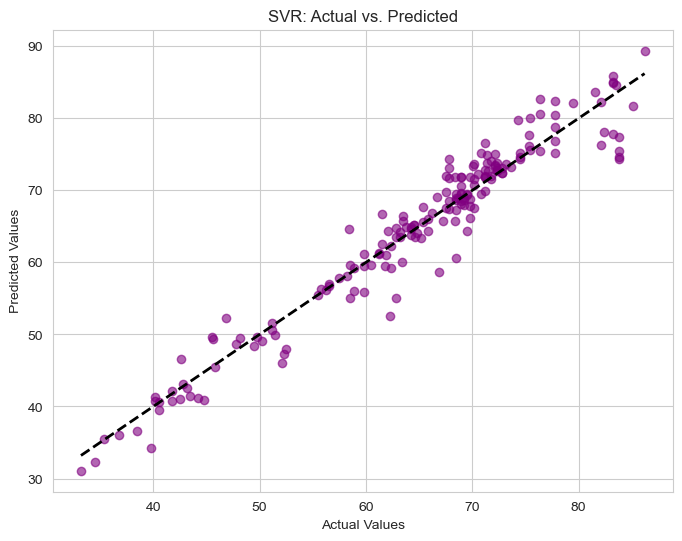

In [9]:
svr_pipeline = Pipeline([
    ('preprocessor', preprocessor), # Numerical features are already scaled by the preprocessor
    ('regressor', SVR()) 
])

svr_param_grid = {
    'regressor__C': [0.1, 1, 10],        # Regularization parameter
    'regressor__gamma': ['scale', 'auto'], # Kernel coefficient
    'regressor__kernel': ['rbf']         # Kernel type (linear can be faster but rbf is common)
}

svr_grid_search = GridSearchCV(svr_pipeline, svr_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
try:
    svr_grid_search.fit(X_train, y_train)
    print('Best SVR Hyperparameters:')
    print(svr_grid_search.best_params_)
    best_svr_model = svr_grid_search.best_estimator_

    # Evaluation
    y_pred_svr = best_svr_model.predict(X_test)
    print('SVR Evaluation:')
    print(f'MAE: {mean_absolute_error(y_test, y_pred_svr):.2f}')
    print(f'MSE: {mean_squared_error(y_test, y_pred_svr):.2f}')
    print(f'R-squared: {r2_score(y_test, y_pred_svr):.2f}')

    # Actual vs. Predicted Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_svr, alpha=0.6, color='purple')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Diagonal line
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('SVR: Actual vs. Predicted')
    plt.show()
except ValueError as e:
    print(f'Error during SVR training/evaluation: {e}')
    print('This might be due to issues with the target variable or feature definitions. Please check the preprocessing steps.')
    print('SVR is also sensitive to unscaled target variables if their range is very large.')
except Exception as e:
    print(f'An unexpected error occurred with SVR: {e}')

## 4. Conclusion\n
This notebook demonstrated the process of loading data, preprocessing it, and training three different regression models: Random Forest, Gradient Boosting, and SVR. Each model was tuned using GridSearchCV, and their performance was evaluated using MAE, MSE, and R-squared metrics.\n
Visualizations for feature importances (for tree-based models) and actual vs. predicted values were also provided.\n
\n
Compare the R-squared, MAE, and MSE values across the models to determine which performed best for this specific dataset and task. Further improvements could involve more extensive feature engineering, trying other models, or more exhaustive hyperparameter tuning.